# Простейшая полносвязная нейросеть для определения тональности текста отзывов на фильмы из IMDb

## Набор данных IMDb movie review

[Набор данных IMDb movie review](https://ai.stanford.edu/~amaas/data/sentiment/) создан для задач определения тональности текста. Набор включает отзывы на фильмы с сайта [IMDb](https://www.imdb.com). Отзывы только явно положительные (оценка >= 7) или отрицательные (оценка <= 4), нейтральные отзывы в набор данных не включались.

Размер набора данных 50 тыс. отзывов:
- Набор данных для обучения - 25 тыс. отзывов
- Набор данных для тестирования - 25 тыс. отзывов

Количество положительных и отрицательных отзывов одинаковое.

Разметка набора данных:
- 0 - отзыв отрицательный
- 1 - отзыв положительный

С точки зрения машинного обучения это задача бинарной классификации.

Набор данных описан в статье: [Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf).

In [4]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from itertools import islice
import matplotlib.pyplot as plt
%matplotlib inline

Определяем максимально возможное количество слов, те слова которые встречаются реже чем слово с указанным индексом в словаре игнорируются

In [2]:
max_words=10000

## Загружаем данные

In [29]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

## Просмотр данных

Рецензия

In [7]:
x_train[5]

[1,
 778,
 128,
 74,
 12,
 630,
 163,
 15,
 4,
 1766,
 7982,
 1051,
 2,
 32,
 85,
 156,
 45,
 40,
 148,
 139,
 121,
 664,
 665,
 10,
 10,
 1361,
 173,
 4,
 749,
 2,
 16,
 3804,
 8,
 4,
 226,
 65,
 12,
 43,
 127,
 24,
 2,
 10,
 10]

Правильный ответ

In [8]:
y_train[5]

0

## Раскодируем текст рецензии

В наборе данных IMDB используется частотное кодирование слов. Загрузим словарь, который использовался для кодирования.

In [9]:
word_index = imdb.get_word_index()

In [19]:
list(islice(word_index.items(), 10))

[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951),
 ('woods', 1408),
 ('spiders', 16115),
 ('hanging', 2345),
 ('woody', 2289),
 ('trawling', 52008)]

Преобразуем словарь, чтобы по номеру получать слово

In [9]:
reverse_word_index = dict()
for key, value in word_index.items():
    reverse_word_index[value] = key

Печатаем 20 самых частых слов

In [10]:
for i in range(1, 21):
    print(i, '->', reverse_word_index[i])


1 -> the
2 -> and
3 -> a
4 -> of
5 -> to
6 -> is
7 -> br
8 -> in
9 -> it
10 -> i
11 -> this
12 -> that
13 -> was
14 -> as
15 -> for
16 -> with
17 -> movie
18 -> but
19 -> film
20 -> on


## Раскодируем сообщения

Служебные коды:  
0 - символ заполнитель  
1 - начало последовательности  
2 - неизвестное слово  

Печатаем первые 20 слов из 5й рецензии в тренировочном датасете без смещения на 3 (тоесть некорректно)

In [11]:
for i in range(20):
    print(reverse_word_index.get(x_train[5][i]))

the
effort
still
been
that
usually
makes
for
of
finished
sucking
ended
and
an
because
before
if
just
though
something


Печатаем первые 20 слов из 5й рецензии в тренировочном датасете 

In [12]:
for i in range(20):
    print(reverse_word_index.get(x_train[5][i]-3, "?"))

*
begins
better
than
it
ends
funny
that
the
russian
submarine
crew
*
all
other
actors
it's
like
those
scenes


Печатаем все слова из 5й рецензии в тренировочном датасете 

In [44]:
message = ''
for code in x_train[5]:
    word = reverse_word_index.get(code - 3, '?')
    message += word + ' '
message

"? begins better than it ends funny that the russian submarine crew ? all other actors it's like those scenes where documentary shots br br spoiler part the message ? was contrary to the whole story it just does not ? br br "

In [33]:
y_train[5]

0

## Подготовка данных для обучения

Длина слов к которой приводится каждая рецензия 

In [22]:
maxlen = 200

Так как для работы нейросети первый слой обязан быть фиксированной длины, используем pad_sequences для обрезки или дополнения вектора с рецензией до maxlen. В случае короткой рецензии проставляем нули с правой стороны

In [30]:
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

In [31]:
x_train[5]

array([   4,  341,    7,   27,  846,   10,   10,   29,    9, 1906,    8,
         97,    6,  236,    2, 1311,    8,    4,    2,    7,   31,    7,
          2,   91,    2, 3987,   70,    4,  882,   30,  579,   42,    9,
         12,   32,   11,  537,   10,   10,   11,   14,   65,   44,  537,
         75,    2, 1775, 3353,    2, 1846,    4,    2,    7,  154,    5,
          4,  518,   53,    2,    2,    7, 3211,  882,   11,  399,   38,
         75,  257, 3807,   19,    2,   17,   29,  456,    4,   65,    7,
         27,  205,  113,   10,   10,    2,    4,    2,    2,    9,  242,
          4,   91, 1202,    2,    5, 2070,  307,   22,    7, 5168,  126,
         93,   40,    2,   13,  188, 1076, 3222,   19,    4,    2,    7,
       2348,  537,   23,   53,  537,   21,   82,   40,    2,   13,    2,
         14,  280,   13,  219,    4,    2,  431,  758,  859,    4,  953,
       1052,    2,    7, 5991,    5,   94,   40,   25,  238,   60,    2,
          4,    2,  804,    2,    7,    4, 9941,  1

In [20]:
y_train[5]

1

## Создание нейронной сети

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(maxlen,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [34]:
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

history = model.fit(x_train,
                    y_train,
                    epochs=25,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4994 - loss: 200.4162 - val_accuracy: 0.4932 - val_loss: 31.3807
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5307 - loss: 19.7568 - val_accuracy: 0.4860 - val_loss: 25.5017
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5195 - loss: 11.5819 - val_accuracy: 0.5020 - val_loss: 7.3845
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5277 - loss: 4.9631 - val_accuracy: 0.5284 - val_loss: 4.1405
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5353 - loss: 4.0374 - val_accuracy: 0.5112 - val_loss: 4.2446
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5367 - loss: 3.6570 - val_accuracy: 0.5056 - val_loss: 4.1014
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5422 - loss: 4.1741 - val_accuracy: 0.4920 - val_loss: 4.5340
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5377 - loss: 3.1480 - val_accura

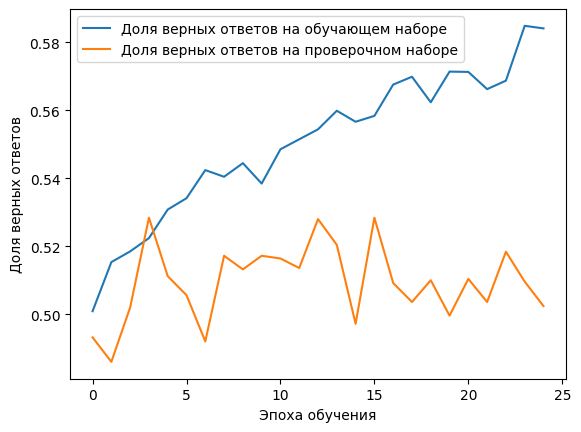

In [37]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Проверяем работу сети на тестовом наборе данных

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

25000/25000 [==============================] - 1s 59us/sample - loss: 1.4626 - acc: 0.5089


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 50.888


Результаты неутешительны, сеть не обучилась корректно